# MCT4052 Workshop 9a: Raw Audio Generation with Tensorflow RNN

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

This notebook present the same application Workshop 7e, but  in this case we use [Tensorflow Recurrent Neural Network architectures](https://www.tensorflow.org/guide/keras/rnn). In this case we can work with a much smnaller input sequence and model  more complex audio signals. Mind that the computational complexity, especially for the inference part can be significant (indeed we use a lowe sampling ratem set to 16KHz).

In the example, at least in the starting form, we generate sinuosid signal, and we use the oldest "sequence_length" samples to predict the next one. After the RNN is defined and trained. The inference process starts with a sample pipeline line full of noise, that we gradually fill up with RNN generated audio samples.

In [1]:
import numpy as np
import pandas as pd
import librosa
import sklearn
import scipy
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
import IPython.display as Ipd
import os
import tensorflow as tf


%config IPCompleter.greedy=True
%matplotlib inline

### 1. Generating a long reference signal that the ANN will learn

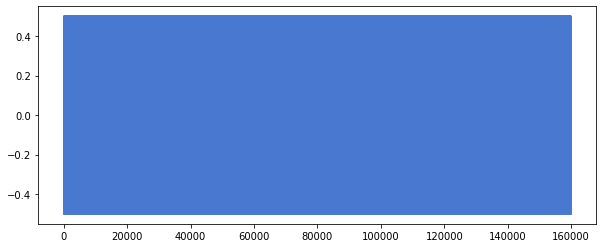

In [2]:
#generating periodic sinusoidal signal

sr = 16000

#frequency
f1 = 440

#amplitude
A = 0.5

t=np.arange(0,10,1/sr)

s = A*np.sin(2*np.pi*f1*t)

plt.figure(figsize=(10, 4))
plt.plot(s)
plt.show()

In [3]:
#setting size of the recursion and size of dataset
input_size = 1 #mono, set to 2 (and modify the code for stereo or to predict a bivariate quantity)
sequence_length = 30 #lenght of sequence passed to the RNN to predict the new sample
dataset_size = 10000

#creating empty arrays for input and output
input_data=np.zeros((dataset_size,sequence_length))
output_data=np.zeros(dataset_size)

i = 0

#taking slizes of recursion_smp samples at random points plus the following sample as target output
while (i < dataset_size):
    index = int(s.size*np.random.random_sample(1))
    if s.size - index < (sequence_length+1):
        continue
    input_data[i,:] = s[index:index+sequence_length]
    output_data[i] = s[index+sequence_length]
    #print(output_data[i],'VS',input_data[i,sequence_length-1])
    i += 1


In [4]:
# for the splitting we still use scikit learn

from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
input_data_train, input_data_test, output_data_train, output_data_test = train_test_split(input_data, output_data, test_size=0.2)


2022-03-24 10:28:03.994319: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


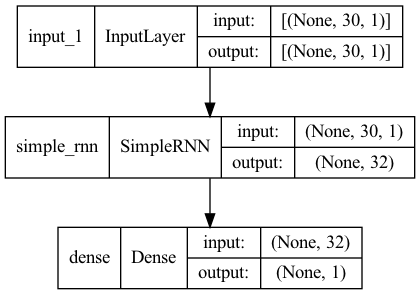

In [5]:
# defining and displaying the model

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(sequence_length, input_size)),
    tf.keras.layers.SimpleRNN(32, activation='relu'), #number of  units is the vector dize for C and H
    tf.keras.layers.Dense(1) # no activation layer on the output, we predict one sample only for mono
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),#learning_rate=0.01
    loss='mean_squared_error')

tf.keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)


In [6]:
callback_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(
    input_data_train,
    output_data_train,
    batch_size=32,
    epochs=100,
    callbacks = [callback_stop],
    validation_split = 0.1
)

Epoch 1/100
225/225 [==============================] - 2s 5ms/step - loss: 0.0174 - val_loss: 2.5538e-05
Epoch 2/100
225/225 [==============================] - 1s 5ms/step - loss: 8.6386e-06 - val_loss: 4.5929e-06
Epoch 3/100
225/225 [==============================] - 1s 4ms/step - loss: 3.6928e-06 - val_loss: 2.8225e-06
Epoch 4/100
225/225 [==============================] - 1s 4ms/step - loss: 2.6551e-06 - val_loss: 2.9364e-06
Epoch 5/100
225/225 [==============================] - 1s 5ms/step - loss: 2.3248e-06 - val_loss: 1.8203e-06
Epoch 6/100
225/225 [==============================] - 1s 6ms/step - loss: 1.6723e-06 - val_loss: 1.3345e-06
Epoch 7/100
225/225 [==============================] - 1s 5ms/step - loss: 1.5105e-06 - val_loss: 1.2507e-06
Epoch 8/100
225/225 [==============================] - 1s 5ms/step - loss: 1.4940e-06 - val_loss: 1.1822e-06
Epoch 9/100
225/225 [==============================] - 1s 4ms/step - loss: 1.3167e-06 - val_loss: 1.2955e-06
Epoch 10/100
225/225 [=

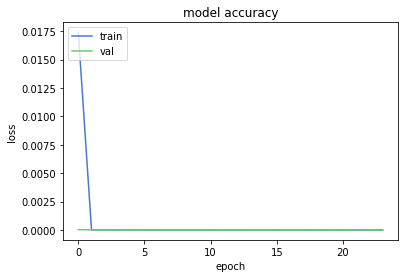

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
output_data_pred = model.predict(input_data_test)

print('Coefficient of determination (r2 score): %.4f'% sklearn.metrics.r2_score(output_data_test, output_data_pred))


Coefficient of determination (r2 score): 1.0000


In [9]:
#size of the generated signal in samples
out_sig_size = 2000

#starting with a sample pipeline full of noise
inout_pipeline = np.random.random_sample(sequence_length)

#empty array for the output signal
sig_out = np.zeros(out_sig_size)

#loop generating signal offline
i = 0
while (i < out_sig_size):
    temp = model.predict(inout_pipeline.reshape(1,-1))
    sig_out[i] = temp
    inout_pipeline = np.append(inout_pipeline,temp)#latest output one at the end
    inout_pipeline = np.delete(inout_pipeline,0)#removing the oldest from the front
    i += 1



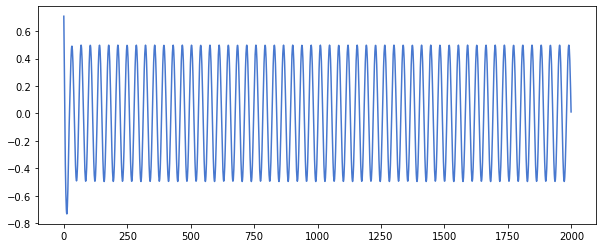

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(sig_out)
plt.show()

Ipd.display(Ipd.Audio(sig_out.flatten(), rate=sr))

### Follow up activities

1. Try different types of RNN cells, such ad the LSTM and GRU available in [tensorflow](https://www.tensorflow.org/guide/keras/rnn).
2. Experiment wirh reducing the lenght of the sequence used as input for the RNN, eventually working with a single sample (this many need to increase the number of units in the RNN). With a single sample you can also optimize the generation part (remove the pipeline for the autoregression).
3. use a different type of audio signals for the training (perhaps a frequency sweep or something more complex), or use an input and output that are perhaps input and output of an audio digital filter.
4. add another RNN layer (this require setting "return_sequences=True" in the first RNN layer).
5. modify the code so that it works with a stereo input and oputput (input_size must be 2), as well as 2 neurons are needed at the output of the network. You can think to work with two independent output neurons by using a non sequential model (more on this [here](https://www.tensorflow.org/guide/keras/functional), which was also used in [this example](https://www.tensorflow.org/tutorials/audio/music_generation)).
